# Package and Data

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from torch import nn, optim
from PIL import Image
import math
import torch.nn.functional as F
from torch.nn import Parameter
file_dir  = "../input/cassava-leaf-disease-classification/train_images"
df = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")

In [ ]:
df

In [ ]:
df["label"].value_counts()

# Data Channels

In [2]:
class LeafDataset(Dataset):
    def __init__(self, df, file_dir, mode = "train", transform = None):
        self.df = df
        self.file_dir = file_dir
        self.mode = mode
        self.transform = transform
        
    def __getitem__(self, index):
        image_name = self.df["image_id"].iloc[index]
        label = self.df["label"].iloc[index]       
        image = Image.open(os.path.join(self.file_dir,image_name))
        #image = image.resize((512,512))
        
        if self.transform != None:
            image = self.transform(image)
        if self.mode == "train" or self.mode == "val":
            return image, label
        else:
            return image
    
    def __len__(self):
        return self.df.shape[0]

In [69]:
train_transform = transforms.Compose([transforms.RandomCrop(448),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(p=0.5),
                                      transforms.RandomRotation(15),
                                      transforms.GaussianBlur(kernel_size = 3),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
val_transform = transforms.Compose([transforms.Resize(448),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

In [4]:
from sklearn.model_selection import train_test_split
train,val = train_test_split(df, test_size= 0.2)

In [88]:
train_data = LeafDataset(train, file_dir, transform =train_transform)
val_data = LeafDataset(val, file_dir, transform =val_transform)

In [89]:
train_loader = DataLoader(train_data, batch_size = 32, shuffle=True)
val_loader = DataLoader(val_data, batch_size = 32, shuffle=True)

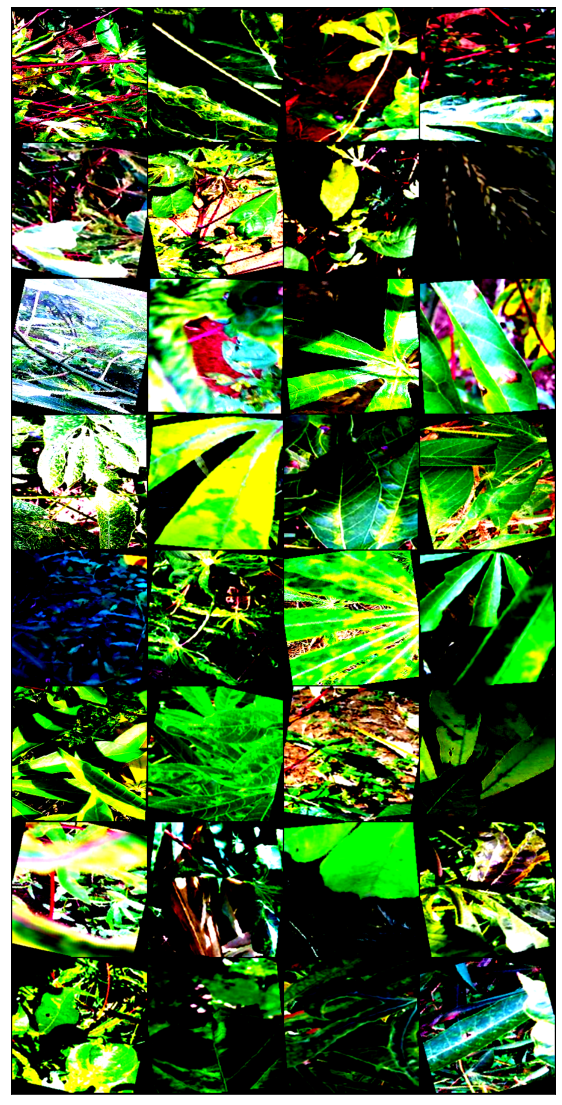

In [10]:
for images, labels in train_loader:
    
    fig, ax = plt.subplots(figsize = (20, 20))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid(images, nrow=4).permute(1,2,0))
    break

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Get a Model

In [13]:
import torchvision.models as models
model = models.resnext50_32x4d(pretrained=True) 
for p in model.parameters(): 
    p.requires_grad = False
model.dropout = nn.Dropout(p=0.5)
model.fc = nn.Sequential(model.dropout,
                         nn.Linear(2048,5))

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

In [14]:
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

# Training

In [81]:
criterion = nn.CrossEntropyLoss(label_smoothing = 0.1)

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [18]:
from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 4
for epoch in range(num_epochs):
    train_num_correct = 0 
    train_num_predictions = 0 
    model.train()
    running_loss = 0

    for images, labels in tqdm(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        _, preds = torch.max(outputs.data,1)
        train_num_correct += (preds == labels).sum().item()
        train_num_predictions += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))

    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):

            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
        
            _, preds = torch.max(outputs.data,1)
            val_num_correct += (preds == labels).sum().item()
            val_num_predictions += labels.size(0)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

100%|██████████| 134/134 [01:34<00:00,  1.41it/s]


[Epoch: 1 / 4], [Trian loss: 1.250932], [Val loss: 1.156713], [Train_Acc: 63.43], [Val_Acc: 68.22]


100%|██████████| 134/134 [01:07<00:00,  1.97it/s]


[Epoch: 2 / 4], [Trian loss: 1.208902], [Val loss: 1.146423], [Train_Acc: 65.57], [Val_Acc: 68.74]


100%|██████████| 134/134 [01:10<00:00,  1.91it/s]


[Epoch: 3 / 4], [Trian loss: 1.207650], [Val loss: 1.140713], [Train_Acc: 65.37], [Val_Acc: 70.21]


100%|██████████| 134/134 [01:09<00:00,  1.94it/s]

[Epoch: 4 / 4], [Trian loss: 1.204905], [Val loss: 1.124961], [Train_Acc: 65.68], [Val_Acc: 68.97]


In [19]:
for p in model.parameters():
    p.requires_grad = True

In [73]:
from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 2
for epoch in range(num_epochs):
    train_num_correct = 0 
    train_num_predictions = 0 
    model.train()
    running_loss = 0

    for images, labels in tqdm(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        _, preds = torch.max(outputs.data,1)
        train_num_correct += (preds == labels).sum().item()
        train_num_predictions += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))

    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):

            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
        
            _, preds = torch.max(outputs.data,1)
            val_num_correct += (preds == labels).sum().item()
            val_num_predictions += labels.size(0)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

100%|██████████| 134/134 [02:21<00:00,  1.05s/it]


[Epoch: 1 / 2], [Trian loss: 0.856347], [Val loss: 0.838303], [Train_Acc: 88.48], [Val_Acc: 89.37]


100%|██████████| 134/134 [02:17<00:00,  1.03s/it]

[Epoch: 2 / 2], [Trian loss: 0.857200], [Val loss: 0.835530], [Train_Acc: 88.22], [Val_Acc: 89.44]


In [77]:
from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 2
for epoch in range(num_epochs):
    train_num_correct = 0 
    train_num_predictions = 0 
    model.train()
    running_loss = 0

    for images, labels in tqdm(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        _, preds = torch.max(outputs.data,1)
        train_num_correct += (preds == labels).sum().item()
        train_num_predictions += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))

    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):

            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
        
            _, preds = torch.max(outputs.data,1)
            val_num_correct += (preds == labels).sum().item()
            val_num_predictions += labels.size(0)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

100%|██████████| 133/133 [02:17<00:00,  1.03s/it]


[Epoch: 1 / 2], [Trian loss: 0.853681], [Val loss: 0.847079], [Train_Acc: 88.58], [Val_Acc: 88.48]


100%|██████████| 133/133 [02:18<00:00,  1.04s/it]

[Epoch: 2 / 2], [Trian loss: 0.850547], [Val loss: 0.850574], [Train_Acc: 88.78], [Val_Acc: 88.01]


In [82]:
from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 2
for epoch in range(num_epochs):
    train_num_correct = 0 
    train_num_predictions = 0 
    model.train()
    running_loss = 0

    for images, labels in tqdm(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        _, preds = torch.max(outputs.data,1)
        train_num_correct += (preds == labels).sum().item()
        train_num_predictions += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))

    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):

            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
        
            _, preds = torch.max(outputs.data,1)
            val_num_correct += (preds == labels).sum().item()
            val_num_predictions += labels.size(0)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

100%|██████████| 135/135 [02:21<00:00,  1.05s/it]


[Epoch: 1 / 2], [Trian loss: 0.639638], [Val loss: 0.605855], [Train_Acc: 88.47], [Val_Acc: 89.72]


100%|██████████| 135/135 [02:18<00:00,  1.03s/it]

[Epoch: 2 / 2], [Trian loss: 0.633906], [Val loss: 0.610679], [Train_Acc: 88.64], [Val_Acc: 89.67]


In [59]:
optimizer.param_groups[-1]["lr"] = 5e-6

In [86]:
from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 2
for epoch in range(num_epochs):
    train_num_correct = 0 
    train_num_predictions = 0 
    model.train()
    running_loss = 0

    for images, labels in tqdm(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        _, preds = torch.max(outputs.data,1)
        train_num_correct += (preds == labels).sum().item()
        train_num_predictions += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))

    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):

            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
        
            _, preds = torch.max(outputs.data,1)
            val_num_correct += (preds == labels).sum().item()
            val_num_predictions += labels.size(0)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

100%|██████████| 135/135 [02:17<00:00,  1.02s/it]


[Epoch: 1 / 2], [Trian loss: 0.630226], [Val loss: 0.617892], [Train_Acc: 88.72], [Val_Acc: 89.84]


100%|██████████| 135/135 [02:18<00:00,  1.02s/it]

[Epoch: 2 / 2], [Trian loss: 0.630318], [Val loss: 0.613993], [Train_Acc: 88.51], [Val_Acc: 89.79]


In [90]:
from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 2
for epoch in range(num_epochs):
    train_num_correct = 0 
    train_num_predictions = 0 
    model.train()
    running_loss = 0

    for images, labels in tqdm(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        _, preds = torch.max(outputs.data,1)
        train_num_correct += (preds == labels).sum().item()
        train_num_predictions += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))

    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):

            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
        
            _, preds = torch.max(outputs.data,1)
            val_num_correct += (preds == labels).sum().item()
            val_num_predictions += labels.size(0)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

100%|██████████| 134/134 [02:17<00:00,  1.03s/it]


[Epoch: 1 / 2], [Trian loss: 0.629248], [Val loss: 0.612666], [Train_Acc: 88.65], [Val_Acc: 89.42]


100%|██████████| 134/134 [02:19<00:00,  1.04s/it]

[Epoch: 2 / 2], [Trian loss: 0.627560], [Val loss: 0.613030], [Train_Acc: 88.90], [Val_Acc: 89.18]


# Save the Model

In [105]:
torch.save(model, "CassavaLeaf-resnext50.h5")

# Testing

In [91]:
file_dir  = "../input/cassava-leaf-disease-classification/test_images"

In [92]:
test = [name for name in (os.listdir(file_dir))]

In [98]:
class LeafTestDataset(Dataset):
    def __init__(self, file_names ,file_dir, transform):
        self.file_names = file_names
        self.file_dir = file_dir
        self.transform = transform
    def __getitem__(self, index):
      
        image = Image.open(os.path.join(self.file_dir,self.file_names[index]))      

        return self.transform(image), self.file_names[index]

    
    def __len__(self):
        return len(self.file_names)

In [99]:
test_transform = transforms.Compose([transforms.Resize(448),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

In [100]:
test_data = LeafTestDataset(test, file_dir, test_transform)

In [101]:
test_loader = DataLoader(test_data, batch_size = 1, shuffle = False)

In [102]:
from tqdm import tqdm
result = {}
model.eval()
with torch.no_grad():  
    for image,file_name in tqdm(test_loader):
        
        image = image.to(device)
        output = model(image)        
        _, pred = torch.max(output.data,1)
        result[file_name[0]] = pred.cpu().detach().numpy()[0]
result

100%|██████████| 1/1 [00:00<00:00, 23.12it/s]


{'2216849948.jpg': 4}

In [103]:
submission = pd.DataFrame(result.items(), columns = ["image_id", "label"])
submission.head()

,image_id,label
0,2216849948.jpg,4


# Output Result

In [104]:
submission.to_csv("submission.csv", index = False)